In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras import backend as K
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

from keras.applications import VGG16
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
from PIL import Image
from tqdm import tqdm, trange

/home/skkulab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
nb_classes = 1  # number of classes
img_width, img_height = 224, 224  # change based on the shape/structure of your images
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 50  # number of iteration the algorithm gets trained.
learn_rate = 1e-5  # sgd learning rate

train_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/train'
validation_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/validation'
test_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/test'

### AlexNet Model

In [3]:
img_input = Input(shape=(img_height, img_width, 3))

x = Conv2D(96, 11, strides=4, padding='same', use_bias=False)(img_input) # 15
x = Activation('relu')(x)

x = Conv2D(256, 5, strides=1, padding='same', use_bias=False)(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x) # 8

x = Conv2D(384, 3, strides=1, padding='same', use_bias=False)(x) # 15
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x) # 8

x = Conv2D(384, 3, strides=1, padding='same', use_bias=False)(x) # 15
x = Activation('relu')(x)
x = Conv2D(256, 3, strides=1, padding='same', use_bias=False)(x)
x = Activation('relu')(x)

model_out = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x) # 8

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Add fully connected layer
x = GlobalAveragePooling2D()(model_out)
x = Dense(4096, activation=None)(x)
x = Activation('relu')(x)
x = Dense(1, activation=None)(x)
out = Activation('sigmoid')(x)

model = Model(img_input, out)
print(model.summary())
print(len(model.trainable_weights))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34848     
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       614400    
_________________________________________________________________
activation_2 (Activation)    (None, 56, 56, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 384)       884736    
__________

In [5]:
model.compile(optimizer=Adam(lr=learn_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(len(model.trainable_weights))

9


### Preparing train, validation data

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=32,
                                                  shuffle=True,
                                                  class_mode='binary')

Found 251702 images belonging to 2 classes.
Found 28298 images belonging to 2 classes.
Found 17714 images belonging to 2 classes.


In [7]:
test_classes = test_generator.classes

len(test_classes[test_classes == 0])

999

### Train model(weight unfreezed)

In [8]:
callback_list = [EarlyStopping(monitor='val_acc', patience=5),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]

In [105]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=5,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             callbacks=callback_list,
                             verbose=1)

/home/skkulab/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/2
100/100 [==============================] - 111s 1s/step - loss: 0.1284 - acc: 0.9609 - val_loss: 0.1033 - val_acc: 0.9695
Epoch 2/2
100/100 [==============================] - 115s 1s/step - loss: 0.1060 - acc: 0.9691 - val_loss: 0.1049 - val_acc: 0.9667


### Fine-Tune model(weight freezed)

In [10]:
def generator(directory, batch_size=32):
    folder =  np.sort(os.listdir(directory))
    real_img = np.asarray(glob.glob(directory + '/' + folder[0]+'/*.png'))
    real_idx = np.arange(len(real_img))
    
    while 1:
        X1 = []
        X2 = []
        y = []
        
        if (len(real_idx) < batch_size):
            real_idx = np.arange(len(real_img))
            continue
        
        for _ in range(batch_size):
            if (len(real_idx) < batch_size):
                real_idx = np.arange(len(real_img))
                break
            random1 = np.random.choice(real_idx, 1, replace=False)
            real_idx = real_idx[~np.isin(real_idx, random1)]
            random2 = np.random.choice(real_idx, 1, replace=False)
            real_idx = real_idx[~np.isin(real_idx, random2)]
            X1.append(np.asarray(Image.open(real_img[random1[0]]).convert("RGB"))/255.)
            X2.append(np.asarray(Image.open(real_img[random2[0]]).convert("RGB"))/255.)
            y.append(np.array([0.]))

        X1 = np.asarray(X1)
        X2 = np.asarray(X2)
        y = np.asarray(y)
        yield [X1, X2], y
        
def generator_res(ft_dir, directory, batch_size=32):
    folder = np.sort(os.listdir(directory))
    real_img = np.asarray(glob.glob(ft_dir + '/' + '0' +'/*.png'))
    real_idx = np.arange(len(real_img))
    random1 = np.random.choice(real_idx, 1, replace=False)
    img = np.asarray(Image.open(real_img[random1[0]]).convert("RGB"))/255.
    fake_img = np.asarray(glob.glob(directory + '/' + folder[1] + '/*.png'))
    fake_idx = np.arange(len(fake_img))
    test_img = np.asarray(glob.glob(directory + '/' + folder[0] + '/*.png'))
    test_idx = np.arange(len(test_img))
    while 1:
        X1 = []
        X2 = []
        y = []
        if (len(fake_idx) < batch_size):
            fake_idx = np.arange(len(fake_img))
            continue
        
        for _ in range(batch_size):
            if np.random.random() < 0.95:
            
                if (len(fake_idx) < batch_size):
                    fake_idx = np.arange(len(fake_img))
                    break
                random2 = np.random.choice(fake_idx, 1, replace=False)
                fake_idx = fake_idx[~np.isin(fake_idx, random2)]
                X1.append(img)
                X2.append(np.asarray(Image.open(fake_img[random2[0]]).convert("RGB"))/255.)
                y.append(np.array([1.]))
            
            else:
                if (len(test_idx) < batch_size):
                    test_idx = np.arange(len(test_img))
                random3 = np.random.choice(test_idx, 1, replace=False)
                test_idx = test_idx[~np.isin(test_idx, random3)]
                X1.append(img)
                X2.append(np.asarray(Image.open(test_img[random3[0]]).convert("RGB"))/255.)
                y.append(np.array([0.]))

        X1 = np.asarray(X1)
        X2 = np.asarray(X2)
        y = np.asarray(y)
        yield [X1, X2], y

In [11]:
def manDist(x):
    result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
    return result

def euclidean_distance(inputs):
    assert len(inputs) == 2, 'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))  

def contrastive_loss(y_true,y_pred):
    margin=1.4
    return K.mean((1. - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.)))

def siamese_acc(y_true, y_pred):
    return K.mean((K.equal(y_true, K.cast(y_pred > 0.4, K.floatx()))), axis=1)

def y_pred_prt(y_true, y_pred):
    return y_pred

input_seq = Input(shape=(224, 224, 3))

In [12]:
ft_dir = '/home/skkulab/ICCV/Dataset/preprocessed_dataset/fine-tune'
ft_datagen = ImageDataGenerator(rescale=1./255)
ft_generator = test_datagen.flow_from_directory(ft_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=32,
                                                  shuffle=False,
                                                  class_mode='binary')

Found 1138 images belonging to 2 classes.


In [13]:
ft_model = Model(img_input, out)
ft_model.set_weights(model.get_weights())
for l in range(len(ft_model.layers) - 2):
    ft_model.layers[l].trainable = False

In [14]:
ft_model.summary()
ft_model.compile(optimizer=Adam(lr=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34848     
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       614400    
_________________________________________________________________
activation_2 (Activation)    (None, 56, 56, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 384)       884736    
__________

In [15]:
history_ft = ft_model.fit_generator(ft_generator, steps_per_epoch=30, epochs=3,
                             callbacks=callback_list, verbose=1)

Epoch 1/3
30/30 [==============================] - 4s 118ms/step - loss: 0.1550 - acc: 0.9375
Epoch 2/3
 1/30 [>.............................] - ETA: 3s - loss: 0.1149 - acc: 0.9375

/home/skkulab/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/skkulab/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


30/30 [==============================] - 4s 122ms/step - loss: 0.1441 - acc: 0.9401
Epoch 3/3
30/30 [==============================] - 3s 100ms/step - loss: 0.1305 - acc: 0.9474


### Siamese model (weight freezed)

In [16]:
base_model = Model(img_input, out)
base_model.set_weights(model.get_weights())
for l in range(len(base_model.layers) - 2):
    base_model.layers[l].trainable = False   

im_in = Input(shape=(224, 224, 3))
x1 = base_model([im_in])

model_top = Model(inputs=[im_in], outputs=x1)
model_top.summary()

left_input = Input(shape=(224, 224, 3))
right_input = Input(shape=(224, 224, 3))

h1 = model_top(left_input)
h2 = model_top(right_input)

distance = Lambda(euclidean_distance)([h1, h2])
siam_model = Model(inputs=[left_input, right_input], outputs=distance)
siam_model.compile(loss='mse', optimizer=SGD(0.001), metrics=['acc'])
siam_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
model_3 (Model)              (None, 1)                 4802593   
Total params: 4,802,593
Trainable params: 4,097
Non-trainable params: 4,798,496
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
_____________________________

In [17]:
train_gen = generator(ft_dir)
test_gen = generator_res(ft_dir, test_dir, 32)

In [18]:
callback_list = [EarlyStopping(monitor='val_acc', patience=3),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)]
output = siam_model.fit_generator(train_gen, steps_per_epoch=15, epochs=3,callbacks=callback_list)

Epoch 1/3
15/15 [==============================] - 4s 249ms/step - loss: 0.0716 - acc: 0.9000


/home/skkulab/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/skkulab/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/3
15/15 [==============================] - 3s 212ms/step - loss: 0.0663 - acc: 0.9143
Epoch 3/3
15/15 [==============================] - 4s 233ms/step - loss: 0.0673 - acc: 0.9057


### Evaluate pre-trained model

In [106]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))
print('test acc:', test_acc)
print('test_loss:', test_loss)

test acc: 0.9962741334537654
test_loss: 0.047870441008158564


In [116]:
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y_pred = predictions.copy()


In [117]:
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

In [118]:
predictions[np.isnan(predictions)] = 0

In [119]:
true_classes = test_generator.classes

In [120]:
report = metrics.classification_report(true_classes, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.07      0.07      0.07       999
           1       0.94      0.95      0.95     16715

    accuracy                           0.90     17714
   macro avg       0.51      0.51      0.51     17714
weighted avg       0.90      0.90      0.90     17714



[[   68   931]
 [  908 15807]]


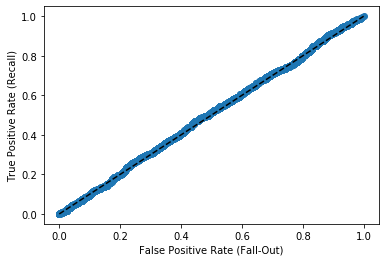

0.5068728016080694

In [121]:
fpr, tpr, thresholds = roc_curve(true_classes, y_pred, pos_label=1.)
cm = confusion_matrix(true_classes, predictions)
print(cm)
recall1 = cm[0][0] / (cm[0][0] + cm[0][1])
fallout1 = cm[1][0] / (cm[1][0] + cm[1][1])
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

plt.plot(fpr, tpr, 'o-')
plt.plot([0, 1], [0, 1], 'k--', label="random guess")

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

roc_auc_score(true_classes, predictions)

In [122]:
print("FPR=FAR", fallout)
print("FNR=FRR", 1-recall)

FPR=FAR 0.02379603399433428
FNR=FRR 0.02197802197802201


In [123]:
eer

0.4942740535436908

In [124]:
thresh

array(0.96525807)

### Evaluate siamese model

In [37]:
score = []
answer = []
max_iter = int(16715 / 32)
j = 0
for i in tqdm(test_gen):
    if j == max_iter:
        break
    y_score = siam_model.predict_on_batch(i[0])
    score.append(y_score)
    answer.append(i[1])
    j += 1

522it [01:32,  5.39it/s]

In [38]:
score = np.concatenate(score)
answer = np.concatenate(answer)

In [94]:
fpr, tpr, thresholds = roc_curve(answer, score, pos_label=1.)
print(roc_auc_score(answer, score))
y_hat = score.copy()
y_hat[y_hat >= 0.4] = 1.
y_hat[y_hat < 0.4] = 0.
print(metrics.classification_report(answer, y_hat))
print(confusion_matrix(answer, y_hat))
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)

0.9949585755062621
              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80       819
         1.0       1.00      0.98      0.99     15885

    accuracy                           0.98     16704
   macro avg       0.84      0.98      0.89     16704
weighted avg       0.98      0.98      0.98     16704

[[  801    18]
 [  378 15507]]


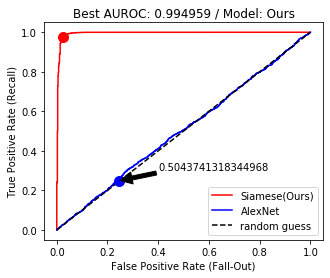

In [104]:
cm = confusion_matrix(answer, y_hat)
recall = cm[0][0] / (cm[0][0] + cm[0][1])
fallout = cm[1][0] / (cm[1][0] + cm[1][1])
fpr2, tpr2, thresholds2 = roc_curve(true_classes, y_pred, pos_label=1.)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, 'r-', label="Siamese(Ours)")
plt.plot(fpr2, tpr2, 'b-', label="AlexNet")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.plot([fallout], [recall], 'ro', ms=10)
plt.plot([fallout1], [recall1], 'bo', ms=10)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.title("Best AUROC: %f / Model: Ours" %(roc_auc_score(answer, score)))
plt.legend(loc='lower right')
plt.annotate(roc_auc_score(true_classes, y_pred), xy=(0.25, 0.25), xytext=(0.4, 0.3), arrowprops={'color':'black'})
plt.show()

In [48]:
print("FPR=FAR", fallout)
print("FNR=FRR", 1-recall)

FPR=FAR 0.02379603399433428
FNR=FRR 0.02197802197802201


In [49]:
eer

0.023051466392787857

In [50]:
thresh

array(0.39771414)

In [57]:
len(y_hat[np.equal(y_hat, answer)]) / len(y_hat)

0.9762931034482759

### Draw plot

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
plt.savefig('/home/skkulab/ICCV/models//xcetion_v1.png')

### Model train(weight unfreezed)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True


model.compile(optimizer=Adam(lr=learn_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(len(model.trainable_weights))

In [ ]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=nb_epoch,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             verbose=1)

In [ ]:
model.save('/home/skkulab/ICCV/models/xception_v2.h5')

### Draw plot

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Load trained model

In [ ]:
loaded_model = load_model('/home/skkulab/ICCV/models/xception_v1.h5')
loaded_model.summary()

### Preparing test data

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='binary')

In [ ]:
test_loss, test_acc = loaded_model.evaluate_generator(test_generator, steps=len(test_generator))
print('test acc:', test_acc)
print('test_loss:', test_loss)

In [ ]:
predictions = loaded_